<a href="https://colab.research.google.com/github/vaibhavsundharam/Face-Anti-Spoofing/blob/master/No_LBP_Replay_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Initializations

In [1]:
import torch
import sys
import os
from __future__ import print_function, division
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
from skimage.transform import resize
import torch.nn as nn
import torch.nn.functional as F
import cv2
import re
import pandas as pd
import numpy as np
import cv2
import PIL
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode


In [2]:
torch.cuda.is_available()

True

In [3]:
# Set device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [5]:
prefix = '/content/gdrive/My Drive/'
# modify "customized_path_to_your_project" 
customized_path_to_your_project = '/content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/' # enter the main directory (change location as required)
sys_path = os.path.join(prefix, customized_path_to_your_project)
sys.path.append(sys_path)
print(f"sys_path: {sys_path}")

sys_path: /content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/


In [6]:
# reading the text file with real and fake faces
data_directory=sys_path+"Data/Replay Attack"
print(f"Data directory location:{data_directory}")

Data directory location:/content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/Data/Replay Attack


#Data Preprocessing

In [7]:
# combining real and fake faces file for training and dev

train_real_txt_file=data_directory+"/train_real.txt"  
train_attack_txt_file=data_directory+"/train_attack.txt"

train_real_images_loc=data_directory+"/train_real/" 
train_attack_images_loc=data_directory+"/train_attack/"

train_data=[(train_real_txt_file, train_real_images_loc, 1), (train_attack_txt_file, train_attack_images_loc, 0 )] # encoding the class

#train_img_list=list() # list containing the location of images 

with open("train_combined.txt", "w") as out:
  for a,b,c in train_data:
    with open(a, "r") as file:
      for line in file:        
        line=line.rstrip()
        out.write(b + "/" +line + "/" + str(c) + "\n")
        
read_file_train=pd.read_csv (r'/content/train_combined.txt', header = None)
read_file_train.columns = ["image"]
read_file_train.to_csv (r"train_combined.csv", index=None)       
print(f"Total number of examples for training: {len(read_file_train)}")

Total number of examples for training: 2950


In [8]:
# combining real and fake faces file for dev and converting it to a csv 

dev_real_txt_file=data_directory+"/dev_real.txt"
dev_attack_txt_file=data_directory+"/dev_attack.txt"

dev_real_images_loc=data_directory+"/dev_real/" 
dev_attack_images_loc=data_directory+"/dev_attack/"

dev_data=[(dev_real_txt_file, dev_real_images_loc, 1),(dev_attack_txt_file, dev_attack_images_loc, 0)]

#dev_img_list=list() # list containing the location of images 

with open("dev_combined.txt", "w") as out:
  for a,b,c in dev_data:
    with open(a, "r") as file:
      for line in file:        
        line=line.rstrip()
        out.write(b + "/" +line + "/" + str(c) + "\n")
        
read_file_dev = pd.read_csv (r'/content/dev_combined.txt', header = None)
read_file_dev.columns = ["image"]
read_file_dev.to_csv (r"dev_combined.csv", index=None)

print(f"Total number of examples for dev set: {len(read_file_dev)}")


Total number of examples for dev set: 2937


In [9]:
# combining real and fake faces file for testing and converting it to a csv 

test_real_txt_file=data_directory+"/test_real.txt"
test_attack_txt_file=data_directory+"/test_attack.txt"

test_real_images_loc=data_directory+"/test_real/" 
test_attack_images_loc=data_directory+"/test_attack/"

test_data=[(test_real_txt_file, test_real_images_loc, 1),(test_attack_txt_file, test_attack_images_loc, 0)]

#test_img_list=list() # list containing the location of images 

with open("test_combined.txt", "w") as out:
  for a,b,c in test_data:
    with open(a, "r") as file:
      for line in file:        
        line=line.rstrip()
        out.write(b + "/" +line + "/" + str(c) + "\n")
        
read_file_test = pd.read_csv (r'/content/test_combined.txt', header = None)
read_file_test.columns = ["image"]
read_file_test.to_csv (r"test_combined.csv", index=None)

print(f"Total number of examples for test set: {len(read_file_test)}")


Total number of examples for test set: 3888


# Data loaders and data augmentation

In [10]:
# custom class to explore dataset
class face_dataset(Dataset):
  def __init__(self, data_split_csv_loc, transform=None): 
    self.data_split_csv_loc=pd.read_csv(data_split_csv_loc)    
    self.transform=transform    

  def __len__(self):  # returns the length of the data set
     return len(self.data_split_csv_loc)

  def __getitem__(self, idx):    
    img_loc=self.data_split_csv_loc.iloc[idx,0][:-2]           
    img_class=int(self.data_split_csv_loc.iloc[idx,0][-1])
    img_transform=self.transform(Image.open(img_loc))    
    
    return  img_transform,   img_class  #---> returned values are a touple and image class 

In [11]:
class normalize_HPF():
  def __init__(self):
    self.kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

  def __call__(self, sample):
    sample = np.array(sample)
    image=cv2.normalize( sample, None, 0, 255, cv2.NORM_MINMAX) # normalization
    image=cv2.filter2D(image, -1, self.kernel) # high pass filtering
    return image

In [12]:
# Here we create two seperate instances of the face_dataset class. One will hold the data set for training and the other will hold data for dev

train_dataset=face_dataset(data_split_csv_loc="/content/train_combined.csv", transform=transforms.Compose([transforms.Resize((150, 150)),
                                                                                                          transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)], p=0.5),
                                                                                                          transforms.RandomHorizontalFlip(),
                                                                                                          normalize_HPF(),
                                                                                                          transforms.ToTensor()]))
dev_dataset=face_dataset(data_split_csv_loc="/content/dev_combined.csv", transform= transforms.Compose([transforms.Resize((150 , 150)), 
                                                                                                      normalize_HPF(),
                                                                                                      transforms.ToTensor()]))
test_dataset=face_dataset(data_split_csv_loc="/content/test_combined.csv", transform= transforms.Compose([transforms.Resize((130, 130)), 
                                                                                                          normalize_HPF(),
                                                                                                          transforms.ToTensor()]))


len_train_dataset, len_dev_dataset, len_test_dataset, =len(train_dataset), len(dev_dataset), len(test_dataset) 
print(f"Total number of elements in training dataset: {len_train_dataset}")
print(f"Total number of elements in dev dataset: {len_dev_dataset}")
print(f"Total number of elements in test dataset: {len_test_dataset}")

Total number of elements in training dataset: 2950
Total number of elements in dev dataset: 2937
Total number of elements in test dataset: 3888


#Data Exploration

In [ ]:
# function for plotting LBP 

def plot(batch):   
  
  fig, axs = plt.subplots(1, batch.shape[0], figsize=(25,25)) 
  for i in range(batch.shape[0]):
    image = batch[i].permute(1, 2, 0)
    axs[i].imshow(image)

In [ ]:
plot_loader=DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8) 

for batch, label  in plot_loader:  # getting one batch for visualizing data  
  print(batch.shape)
  break

torch.Size([16, 3, 150, 150])


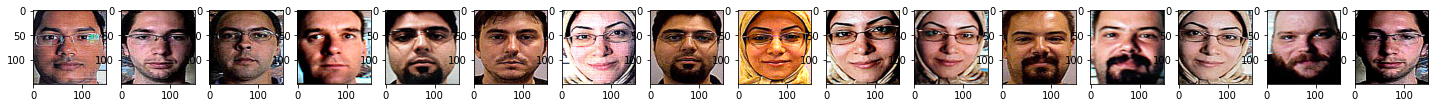

In [ ]:
plot(batch)

#Helper functions

In [13]:
# get true positives, true negatives,  false positives and false negatives

def confusion_matrix(ys, y_preds):
  ys=ys.detach()
  ys=ys.to("cpu")
  y_preds=y_preds.detach()
  y_preds=y_preds.to("cpu")

  ys=np.asarray(ys)
  y_preds=np.asarray(y_preds)  

  tp=np.sum((y_preds == 1) & (ys == 1))
  tn=np.sum((y_preds == 0) & (ys == 0))
  fp=np.sum((y_preds == 1) & (ys == 0))
  fn=np.sum((y_preds == 0) & (ys == 1))

  print(f"tp:{tp}, tn: {tn}, fp:{fp}, fn: {fn}") 

  return tp, tn, fp, fn

In [14]:
# def confusion matrix test

a=torch.Tensor([1,1,1,0,0,0])
b=torch.Tensor([0,1,0,1,0,1])

TP, TN, FP, FN=confusion_matrix(a, b)
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
print("Answer:TP: 1, TN: 1, FP: 2, FN: 2")

tp:1, tn: 1, fp:2, fn: 2
TP: 1, TN: 1, FP: 2, FN: 2
Answer:TP: 1, TN: 1, FP: 2, FN: 2


In [15]:
# HTER claculation for test and validation
def HTER(model, loss_criterion, loader):
  Ys=list()
  Y_preds=list()
  Loss_total=0    
  total_step=len(loader)
  
  for touple, label in loader:
    batch=touple
    batch=batch.to(device=device, dtype=torch.float)
    label=label.to(device=device, dtype=torch.long)
    Ys.append(label) 
    Y_pred=model(batch)       
    Y_preds.append(torch.argmax(Y_pred, dim=1))    
    Loss=loss_criterion(Y_pred,label)    
    Loss_total += Loss.item() 
    
    
  Y= torch.cat(Ys, dim=0)
  Y_pred=torch.cat(Y_preds, dim=0)
  tp, tn, fp, fn =confusion_matrix(Y, Y_pred)
  hter=1-(0.5*((tp/(tp+fn))+(tn/(tn+fp))))
  
  return (hter*100, Loss_total/total_step)

In [16]:
# solver function for Neural Network

def Solver_NN(model, train_loader, dev_loader, optim, criterion, device,  scheduler, print_every=10, epoch=51, lr=1e-1):
  print("Solver Initiated")  
  model=model.to(device) # sending model to GPU
  print("Model successfully sent to the GPU\n")

  print_every=print_every
  total_step = len(train_loader)
  counter=0

  for e in range(epoch):
    running_loss = 0.0    
    epoch_loss=0.0
    for i, (x,y) in enumerate(train_loader):
      optim.zero_grad()

      X=x      
      #print(X.shape)
      X=X.to(device=device, dtype=torch.float)
      y=y.to(device=device, dtype=torch.long)
     
      #forward pass########
      y_pred=model(X)                  
      loss=criterion(y_pred, y)          
      ####################
      
      # backward pass#######     
      loss.backward()
      optim.step()
      ####################      
      running_loss += loss.item()
      epoch_loss+=running_loss
      if (i+1) % print_every == 0:       # print every 10
        print ("Epoch [{}/{}], Step [{}/{}] Loss: {}".format(counter+1, epoch, i+1, total_step, running_loss/print_every))
        running_loss = 0.0
    counter+=1     

    with torch.no_grad():            
      train_hter, train_loss=HTER(model=model, loss_criterion=criterion, loader=train_loader)    
      dev_hter, dev_loss=HTER(model=model, loss_criterion=criterion, loader=dev_loader)           
      print(f"Train loss in epoch {e+1} is {(train_loss)} and Train HTER in epoch {e+1}: {train_hter}") 
      print(f"Dev loss in epoch {e+1} is {(dev_loss)} and Dev HTER in epoch {e+1}: {dev_hter}")  
      scheduler.step(dev_loss)    
    torch.save(model.state_dict(), sys_path + 'Codes/Replay Attack/weights_replay_attack_1FPS/weights1/Resnet_Replay_attack_No_LBP_'+ str(e+1) + "_" + str(np.floor(dev_hter))+'.pkl') 
    print("Model saved successfully!\n")
    
  return model

In [17]:
##DO NOT CHANGE##
class Resnet(nn.Module):
  def __init__(self,  model):
    super().__init__()    
    self.cnn=nn.Sequential(*(list(model.children())[0:5]), nn.AdaptiveAvgPool2d(output_size=(1, 1)), nn.Flatten())    
    self.fc=nn.Sequential(nn.Linear(256, 256), nn.Dropout(p=0.5), nn.Linear(256, 2))     

  def forward(self, x):  

    x=self.cnn(x)
    #print(f"2: {x.shape}")

    x=self.fc(x)
    #print(f"3 {x.shape}")

    return x

# Training

In [ ]:
resnet=torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False)
model= Resnet(resnet )
print(model)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip


Resnet(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, 

In [ ]:
#criterion and optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr=0.001
criterion=nn.CrossEntropyLoss(reduction='mean') # loss criterion 
optim=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1.0) # optimizer 
scheduler =  ReduceLROnPlateau(optim, mode='min', factor=0.1, patience= 2, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

In [ ]:
# GPU Access and model parameters
use_cuda = True
if use_cuda and torch.cuda.is_available():
  print("Running on Cuda")
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable parameters:",params)

Running on Cuda
Learnable parameters: 291650


In [ ]:
# loading training and validation data for the neural network
train_loader=DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8) 
dev_loader=DataLoader(dev_dataset, batch_size=256, shuffle=True, num_workers=8) 

In [ ]:
model=Solver_NN(model, train_loader, dev_loader, optim,criterion, device, scheduler, print_every=5, epoch=101, lr=lr)

Solver Initiated
Model successfully sent to the GPU

Epoch [1/101], Step [5/12] Loss: 0.512435519695282
Epoch [1/101], Step [10/12] Loss: 0.47997487187385557
tp:60, tn: 2232, fp:1, fn: 657
tp:61, tn: 2217, fp:0, fn: 659
Train loss in epoch 1 is 0.4588593716422717 and Train HTER in epoch 1: 45.83829098329171
Dev loss in epoch 1 is 0.45503925283749896 and Dev HTER in epoch 1: 45.76388888888889
Model saved successfully!

Epoch [2/101], Step [5/12] Loss: 0.44171561002731324
Epoch [2/101], Step [10/12] Loss: 0.4551042139530182
tp:93, tn: 2231, fp:2, fn: 624
tp:75, tn: 2217, fp:0, fn: 645
Train loss in epoch 2 is 0.443525068461895 and Train HTER in epoch 2: 43.559427154867926
Dev loss in epoch 2 is 0.4467189187804858 and Dev HTER in epoch 2: 44.791666666666664
Model saved successfully!

Epoch [3/101], Step [5/12] Loss: 0.4461588144302368
Epoch [3/101], Step [10/12] Loss: 0.4299322545528412
tp:61, tn: 2233, fp:0, fn: 656
tp:38, tn: 2217, fp:0, fn: 682
Train loss in epoch 3 is 0.42980087300141

#Testing

In [18]:
criterion=nn.CrossEntropyLoss(reduction='mean') # loss criterion
resnet=torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False)
model_test= Resnet(resnet)
print(model_test)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip


Resnet(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, 

In [ ]:
model_test.load_state_dict(torch.load("/content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/Codes/Replay Attack/Code : Replay Attack 1 FPS/DND/Final Replay Attack/weights1 epoch 44/Resnet_Replay_attack_No_LBP_44_0.0.pkl"))

<All keys matched successfully>

In [ ]:
test_loader=DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=8) 
len_test_dataset= len(test_dataset)

print(f"Total number of elements in test dataset: {len_test_dataset}")

Total number of elements in test dataset: 3888


In [ ]:
model_test=model_test.to(device)
with torch.no_grad():
  model_test.eval()   
  test_hter, test_loss=HTER(model=model_test, loss_criterion=criterion, loader=test_loader)
  print(f"Test loss  is {test_loss}")
  print(f'Test HTER: {test_hter}\n')

tp:950, tn: 2936, fp:2, fn: 0
Test loss  is 0.09263572096824646
Test HTER: 0.034036759700484254



#Attacking the model with occlusions 



In [19]:
import dlib
from math import hypot
import random

In [20]:
class add_occlusions():

  def __init__(self, glasses_list, nose_list, mask_list, detector, predictor, p_glasses = 0.5, p_nose = 0.5, p_mask = 0.5):
    self.glasses_list = glasses_list
    self.nose_list = nose_list
    self.mask_list = mask_list
    self. detector= detector
    self.predictor = predictor 
    self.p_glasses  = p_glasses
    self.p_nose = p_nose
    self.p_mask = p_mask
    self.count1 = 0
    self.count2 = 0
    self.count3 = 0

  def add_glasses(self, face_img,  landmarks):
      overlay_t_img  = cv2.imread(random.choice(glasses_list), -1) # randomly selecting a nose image with transparent background
      # eye co-ordiantes
      eye_left = (landmarks.part(0).x, landmarks.part(0).y)
      eye_right = (landmarks.part(16).x, landmarks.part(16).y)
      eye_center = (landmarks.part(28).x, landmarks.part(28).y)
      glasses_width = int(np.floor(hypot(eye_left[0]-eye_right[0], eye_left[1] - eye_right[1])))    
      glasses_height = int(np.floor(glasses_width*(overlay_t_img.shape[0]/overlay_t_img.shape[1])))      
      roi_top_left =  (abs(int(eye_center[0] - glasses_width/2)),abs(int(eye_center[1] - glasses_height/2)))
      roi_bottom_right = (abs(int(eye_center[0] + glasses_width/2)), abs(int(eye_center[1] + glasses_height/2)))
      roi =  face_img[roi_top_left[1]: roi_top_left[1] + glasses_height, roi_top_left[0]: roi_top_left[0]+glasses_width]
      overlay_t_img = cv2.resize(overlay_t_img, (roi.shape[1], roi.shape[0]))        
      # Split out the transparency mask from the colour info
      overlay_mask = overlay_t_img[: , : , 3:]  # And the alpha plane  
      overlay_img = overlay_t_img[: , : , :3] # Grab the BRG planes
      # Let's shrink and blur it a little to make the transitions smoother...
      overlay_mask = cv2.erode(overlay_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
      overlay_mask = cv2.blur(overlay_mask, (3, 3))    
      # Again calculate the inverse mask
      background_mask = np.subtract(255,overlay_mask)           
      # Turn the masks into three channel, so we can use them as weights      
      overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
      background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)    
      # Create a masked out face image, and masked out overlay
      # We convert the images to floating point in range 0.0 - 1.0 
      face_part = face_part = (roi  * (background_mask * (1 / 255.0)))  
      overlay_part = (overlay_img * (overlay_mask * (1 / 255.0)))
      dst = cv2.add(face_part,overlay_part)
      face_img[roi_top_left[1]: roi_top_left[1] + glasses_height, roi_top_left[0]: roi_top_left[0]+glasses_width]=dst           
      return face_img
    # ==============================================================================

  def add_nose(self, face_img,  landmarks ):
      overlay_t_img  = cv2.imread(random.choice(self.nose_list), -1) # randomly selecting a nose image with transparent background
      # Nose co-ordinate
      nose_top = (landmarks.part(29).x, landmarks.part(29).y)
      nose_center = (landmarks.part(30).x, landmarks.part(30).y)
      nose_left = (landmarks.part(31).x, landmarks.part(31).y)
      nose_right = (landmarks.part(35).x, landmarks.part(35).y)
      nose_bottom = (landmarks.part(33).x, landmarks.part(33).y)
      nose_width = int(hypot(nose_left[0] - nose_right[0], nose_left[1] - nose_right[1]) * 1.2)
      nose_height = int(nose_width*(overlay_t_img.shape[0]/overlay_t_img.shape[1]))
      roi_top_left =  (abs(int(nose_center[0] - nose_width/2)), abs(int(nose_center[1] - nose_height/2)))
      roi_bottom_right = (abs(int(nose_center[0] + nose_width/2)), abs(int(nose_center[1] + nose_height/2)))
      roi =  face_img[roi_top_left[1]: roi_top_left[1] + nose_height, roi_top_left[0]: roi_top_left[0]+nose_width]
      overlay_t_img = cv2.resize(overlay_t_img, (roi.shape[1], roi.shape[0]))          
      # Split out the transparency mask from the colour info
      overlay_mask = overlay_t_img[: , : , 3:]  # And the alpha plane  
      overlay_img = overlay_t_img[: , : , :3] # Grab the BRG planes
      # Let's shrink and blur it a little to make the transitions smoother...
      overlay_mask = cv2.erode(overlay_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
      overlay_mask = cv2.blur(overlay_mask, (3, 3))          
      # Again calculate the inverse mask
      background_mask = 255 - overlay_mask              
      # Turn the masks into three channel, so we can use them as weights
      overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
      background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)          
      # Create a masked out face image, and masked out overlay
      # We convert the images to floating point in range 0.0 - 1.0
      face_part = face_part = (roi  * (background_mask * (1 / 255.0)))
      overlay_part = (overlay_img * (overlay_mask * (1 / 255.0)))    
      dst = cv2.add(face_part,overlay_part)
      face_img[roi_top_left[1]: roi_top_left[1] + nose_height, roi_top_left[0]: roi_top_left[0]+nose_width] = dst          
      return face_img
      # ==============================================================================
      
  def add_mask(self, face_img, landmarks):
      overlay_t_img  = cv2.imread(random.choice(self.mask_list), -1) # randomly selecting a nose image with transparent background      
      # Face co-ordinate  
      face_left = (landmarks.part(4).x, landmarks.part(4).y)  
      face_right = (landmarks.part(14).x, landmarks.part(14).y)  
      face_bottom = (landmarks.part(8).x, landmarks.part(8).y)
      lip_center = (landmarks.part(62).x, landmarks.part(62).y)
      mask_top = (landmarks.part(29).x, landmarks.part(29).y)
      mask_width = int(hypot(face_left[0] - face_right[0], face_left[1] - face_right[1]))
      mask_height = int((hypot(mask_top[0] - face_bottom[0], mask_top[1] - face_bottom[1] )))  
      roi_top_left =  (abs(int(lip_center[0] - mask_width/2)), abs(int(lip_center[1] - mask_height/2)))
      roi_bottom_right = (abs(int(lip_center[0] + mask_width/2)), abs(int(lip_center[1] + mask_height/2)))
      roi =  face_img[roi_top_left[1]: roi_top_left[1] + mask_height, roi_top_left[0]: roi_top_left[0]+mask_width]       
      overlay_t_img = cv2.resize(overlay_t_img, (roi.shape[1], roi.shape[0]))          
      # Split out the transparency mask from the colour info
      overlay_mask = overlay_t_img[: , : , 3:]  # Grab the alpha plane  
      overlay_img = overlay_t_img[: , : , :3] # Grab the BRG planes
      # Let's shrink and blur it a little to make the transitions smoother...
      overlay_mask = cv2.erode(overlay_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
      overlay_mask = cv2.blur(overlay_mask, (3, 3))          
      # Again calculate the inverse mask
      background_mask = 255 - overlay_mask            
      # Turn the masks into three channel, so we can use them as weights
      overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
      background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)        
      # Create a masked out face image, and masked out overlay
      # We convert the images to floating point in range 0.0 - 1.0
      face_part = face_part = (roi  * (background_mask * (1 / 255.0)))
      overlay_part = (overlay_img * (overlay_mask * (1 / 255.0)))    
      dst = cv2.add(face_part,overlay_part)
      face_img[roi_top_left[1]: roi_top_left[1] + mask_height, roi_top_left[0]: roi_top_left[0]+mask_width] = dst          
      return face_img
    # ==============================================================================
  def __call__(self, sample):          
    img = np.array(sample)    
    img_copy = img.copy()
    faces = self.detector(img, 1)
    if len(faces) == 0:      
      self.count1+=1
      #print("failed to detect face",self.count1)      
      return img
    else:
      for face in faces:
        landmarks = self.predictor(img_copy, face)
        try:  
          if torch.rand(1) < self.p_glasses:                  
            img = self.add_glasses(img_copy, landmarks)   
          if torch.rand(1) < self.p_nose:       
            img = self.add_nose(img_copy, landmarks) 
          if torch.rand(1) < self.p_mask:         
            img = self.add_mask(img_copy, landmarks)      
          self.count2+=1
          #print("occlusion added", self.count2)                    
          return img
        except:       
          self.count3+=1   
          #print("exception encountered", self.count3)                    
          return img        
    

In [21]:
detector=dlib.get_frontal_face_detector() # face detector
model_path= "/content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/Face landmark detection and adding filters/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(model_path)

In [22]:
glasses_list=["/content/1.png", "/content/2.png", "/content/3.png", "/content/4.png", "/content/9.png" ] # list of sunglasses
nose_list=["/content/5.png", "/content/6.png", "/content/7.png",  "/content/8.png"] #list of noses
mask_list=["/content/11.png"] # list of masks

In [33]:
occlusions = add_occlusions(glasses_list, nose_list, mask_list, detector, predictor, p_glasses = 0.5, p_nose = 0.5, p_mask = 0.5)

In [34]:
test_dataset_attack=face_dataset(data_split_csv_loc="/content/test_combined.csv", transform= transforms.Compose([transforms.Resize((130,130)), 
                                                                                                                 occlusions,
                                                                                                                 normalize_HPF(),                                                                                                                                                                                                                                                                                                                                                 
                                                                                                                 transforms.ToTensor()]))
len_test_dataset_attack = len(test_dataset_attack)
print(f"Total number of elements in test dataset: {len_test_dataset_attack}")

Total number of elements in test dataset: 3888


## Data exploration

In [35]:
# function for plotting LBP 
def plot(batch):     
  fig, axs = plt.subplots(1, batch.shape[0], figsize=(25,25)) 
  for i in range(batch.shape[0]):
    image = batch[i].permute(1, 2, 0)
    axs[i].imshow(image)

In [40]:
loader = DataLoader(test_dataset_attack, batch_size=10, shuffle=False, num_workers=1)

for batch, label  in loader:  # getting one batch for visualizing data  
  print(batch.shape)
  print("")
  break  

torch.Size([10, 3, 130, 130])



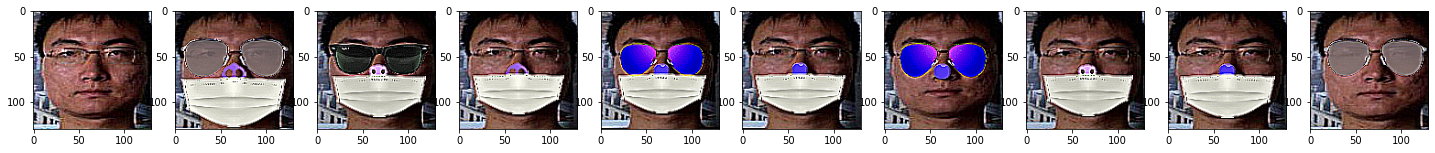

In [41]:
plot(batch)

## Testing of the attack data

In [ ]:
criterion=nn.CrossEntropyLoss(reduction='mean') # loss criterion
resnet=torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False)
model_attack= Resnet(resnet)
print(model_attack)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Resnet(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, 

In [ ]:
model_attack.load_state_dict(torch.load("/content/gdrive/My Drive/Machine Learning/Face Anti-spoofing/Codes/Replay Attack/Code : Replay Attack 1 FPS/DND/Final Replay Attack/weights1 epoch 44/Resnet_Replay_attack_No_LBP_44_0.0.pkl"))

<All keys matched successfully>

In [ ]:
test_loader_attack=DataLoader(test_dataset_attack, batch_size=1000, shuffle=False, num_workers=8) 
len_test_dataset_attack= len(test_dataset_attack)

print(f"Total number of elements in test dataset: {len_test_dataset_attack}")

Total number of elements in test dataset: 3888


In [ ]:
model_attack=model_attack.to(device)
with torch.no_grad():
  model_attack.eval()   
  test_hter, test_loss=HTER(model=model_attack, loss_criterion=criterion, loader=test_loader_attack)
  print(f"Test loss  is {(test_loss)}")
  print(f'Test HTER: {test_hter}\n')

tp:498, tn: 2937, fp:1, fn: 452
Test loss  is 0.3047267245128751
Test HTER: 23.80649206406076

